In [12]:
import jax
from jax import numpy as jnp
from jax import random, grad, vmap, jit, tree_multimap, tree_map
from jax.experimental import stax, optimizers
from jax.experimental.stax import Conv, Dense, MaxPool, Relu, Tanh, Flatten, LogSoftmax, Softmax

from joblib import Parallel, delayed

from policy import Policy
from learners import pwl, get_network
from utils import make_plot, make_envs, plot_and_evaluate

from copy import deepcopy

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure, axis

import cloudpickle
import h5py

import gym
from gym import wrappers

import io
import base64
from IPython.display import HTML

import numpy as np
import pandas as pd
import sys, os, math, time, pickle, itertools
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
## verify Jax is using the GPU
from jax.lib import xla_bridge
print(xla_bridge.get_backend().platform)

gpu


In [14]:
## Instantiate global rng for reproducability
rng = random.PRNGKey(0)

In [15]:
cartpole_expert_params = tree_map(jnp.array,pickle.load(open('cartpolev1_ppo2_expert.pkl','rb')))
lander_expert_params = tree_map(jnp.array,pickle.load(open('lander_ppo2_expert.pkl','rb')))
hopper_expert_params = tree_map(jnp.array,pickle.load(open('halfcheetah_ppo2_tanh_expert.pkl','rb')))
half_cheetah_expert_params = tree_map(jnp.array,pickle.load(open('halfcheetah_ppo2_tanh_expert.pkl','rb')))

In [16]:
env, envs = make_envs('CartPole-v1', 8)
#env, envs = make_envs('LunarLander-v2')
#env, envs = make_envs('HalfCheetah-v2')
discrete = True

set_state = False
if hasattr(env, 'sim'):
    invert_op = getattr(env.sim, "set_state", None)
    if callable(invert_op):
        set_state = True

env_expert, env_noisy_expert, env_dagger, \
env_active_dagger, env_aggrevate, env_active_aggrevate, env_uncactive_aggrevate, env_uncactive_dagger = envs

max_steps = env.spec.max_episode_steps

init_obs = env.reset()
in_shape = (-1,) + (init_obs.shape[0],)

environments = [env_expert, env_noisy_expert, env_dagger, 
                env_active_dagger, env_aggrevate, env_active_aggrevate,
                env_uncactive_aggrevate, env_uncactive_dagger]

In [17]:
#expname = './experts/HalfCheetah-v2.pkl'
expert_network = 'cartpole'
expert_params = cartpole_expert_params
net_init_expert, net_apply_expert, net_walk_expert = get_network('{}-expert'.format(expert_network))
#m = cloudpickle.load(open(expname,'rb'))['GaussianPolicy']['obsnorm']['Standardizer']['mean_1_D']
#ms= cloudpickle.load(open(expname,'rb'))['GaussianPolicy']['obsnorm']['Standardizer']['meansq_1_D']
m = 0.0
ms = 1.0
std = np.sqrt(np.maximum(0.0, ms - np.square(m)))

net_init, net_apply, net_walk = get_network('agent-small',outshape=2)

out_shape, init_params = net_init_expert(rng, in_shape)
expert = Policy(rng, in_shape, (net_init_expert, net_apply_expert, net_walk_expert),name='expert', discrete=discrete, trainable=False)
expert.params=expert_params
expert.std_mean = m
expert.std_std = std

In [18]:
n_actions_init = 1
init_action, _, _ = expert.take_action(init_obs)
obs_data = jnp.array([init_obs])
act_data = jnp.array([init_action])
act_data = act_data.reshape(n_actions_init, act_data.shape[1])

In [19]:
#%%prun -s cumulative
num_episodes = 10
num_rollouts = 10
b = 0.5 # b = 0.5 for , 0.1 for cheetah
b2 = 1.0
dsct_fctr = 0.95

obs_data = jnp.array([init_obs])
act_data = jnp.array([init_action])
act_data = act_data.reshape(n_actions_init, act_data.shape[1])

expert = Policy(rng, in_shape, (net_init_expert, net_apply_expert, net_walk_expert), 
                env=env_expert, name='expert', discrete=discrete, trainable=False)
expert.params = expert_params
#expert.std_mean = m
#expert.std_std = std

#dagger = Policy(rng, in_shape, (net_init, net_apply, net_walk),env=env_dagger, name='dagger', discrete=discrete)
active_dagger = Policy(rng, in_shape, (net_init, net_apply, net_walk), 
                       env=env_active_dagger, name='activedagger', 
                       discrete=discrete, active=True, constrained=True)
#aggrevate = Policy(rng, in_shape, (net_init, net_apply, net_walk),
#                   env=env_aggrevate, name='aggrevate', 
#                   discrete=discrete, cost_sensitive=True)
active_aggrevate = Policy(rng, in_shape, (net_init, net_apply, net_walk),
                          env=env_active_aggrevate, name='activeaggrevate', 
                          discrete=discrete, active=True, constrained=True, cost_sensitive=True)

dagger = Policy(rng, in_shape, (net_init, net_apply, net_walk), 
                       env=env_dagger, name='dagger', 
                       discrete=discrete, active=True, constrained=False) 

aggrevate = Policy(rng, in_shape, (net_init, net_apply, net_walk),
                          env=env_aggrevate, name='aggrevate', 
                          discrete=discrete, active=True, constrained=False, cost_sensitive=True)

unc_active_dagger = Policy(rng, in_shape, (net_init, net_apply, net_walk), 
                       env=env_uncactive_dagger, name='uncactivedagger', 
                       discrete=discrete, active=True, constrained=False)

unc_active_aggrevate = Policy(rng, in_shape, (net_init, net_apply, net_walk),
                          env=env_uncactive_aggrevate, name='uncactiveaggrevate', 
                          discrete=discrete, active=True, constrained=False, cost_sensitive=True)

#innactive_policies = [expert, dagger, aggrevate]
innactive_policies = [expert]
#active_policies = [active_dagger, active_aggrevate]
active_policies = [active_dagger, active_aggrevate, dagger, aggrevate, unc_active_dagger, unc_active_aggrevate]
policies = innactive_policies + active_policies


# aggregate initial data
for policy in policies:
    policy.aggregate((obs_data,act_data))
 
for i in tqdm(range(num_episodes)): #Dagger main loop
    for policy in policies:
        policy.init_policy()
        if policy.trainable:
            if policy.constrained:
                policy.fit_policy(constraints=(None,None))
            else:
                policy.fit_policy()
            
    new_observations, new_actions, Vs = ([] for _ in range(3))
    
    for j in tqdm(range(num_rollouts), position=1, desc='rollout', leave=False):
        for policy in policies:
            policy.reset_env()
            
        r_t = []
        d_i = 0
        for k in range(max_steps):            
            for policy in policies:
                expert_action_logits, expert_action, _ = expert.take_action(policy.cur_obs)
                policy.expert_observations.append(policy.cur_obs)
                policy.expert_actions.append(expert_action_logits)
                if policy.active:
                    self_action_logits, self_action, conf = policy.take_action(policy.cur_obs) 
                    policy.self_observations.append(policy.cur_obs)
                    policy.self_actions.append(self_action_logits)
                    query = random.bernoulli(rng, p=b/(b + conf.item()))
                    policy.cur_active_mask.append(query or (i==0))
                    query_self = random.bernoulli(rng, p=b2/(b2 + conf.item()))
                    policy.cur_self_mask.append(~query and ~query_self)
                """
                if i < 2 or (policy.cur_obs[3] > 0):
                    policy.expert_observations.append(policy.cur_obs)
                    policy.expert_actions.append(expert_action_logits)
                    if policy.active:
                        self_action_logits, self_action, conf = policy.take_action(policy.cur_obs) 
                        policy.self_observations.append(policy.cur_obs)
                        policy.self_actions.append(self_action_logits)
                        query = 1
                        policy.cur_active_mask.append(query or (i==0))
                        query_self = random.bernoulli(rng, p=b2/(b2 + conf.item()))
                        policy.cur_self_mask.append((not query) and (not query_self))
                else:
                    policy.expert_observations.append(policy.cur_obs)
                    policy.expert_actions.append(expert_action_logits)
                    if policy.active:
                        self_action_logits, self_action, conf = policy.take_action(policy.cur_obs) 
                        policy.self_observations.append(policy.cur_obs)
                        policy.self_actions.append(self_action_logits)
                        query = 0
                        query_self = 1
                        if policy.name not in ["dagger","aggrevate"]:
                            policy.cur_active_mask.append(query or (i==0))
                            query_self = random.bernoulli(rng, p=b2/(b2 + conf.item()))
                        policy.cur_self_mask.append((not query) and (not query_self))                         
                """

            doneall=True
            for policy in policies:
                if not policy.done:
                    obs, r, done = policy.step(k+1)
                    policy.r_t.append(r)
                    doneall=False
                
            if doneall: break

        for policy in policies:
            policy.rewards[-1].append(policy.reward_accum)

    for policy in tqdm(policies,desc='data aggregation', position=2, leave=False):
        policy.aggregate()
    #Parallel(n_jobs=-1, prefer="threads")(delayed(policy.aggregate()) for policy in policies)
    
    print('Epoch: {}'.format(i))
    for policy in policies:
        print('{}: {} {}'.format(policy.name, np.mean(policy.rewards[-1]), policy.num_data[-1]))

Epoch: 0
expert: 500.0 5001
activedagger: 9.6 5001
activeaggrevate: 9.6 5001
dagger: 9.6 5001
aggrevate: 9.6 5001
uncactivedagger: 9.6 5001
uncactiveaggrevate: 9.6 5001


Epoch: 1
expert: 500.0 10001
activedagger: 45.5 10001
activeaggrevate: 45.5 10001
dagger: 42.3 10001
aggrevate: 42.7 10001
uncactivedagger: 42.3 10001
uncactiveaggrevate: 42.7 10001


Epoch: 2
expert: 500.0 15001
activedagger: 409.5 12207
activeaggrevate: 411.0 12378
dagger: 343.8 12172
aggrevate: 347.8 12291
uncactivedagger: 343.8 12172
uncactiveaggrevate: 347.8 12291


Epoch: 3
expert: 500.0 20001
activedagger: 500.0 14523
activeaggrevate: 500.0 14794
dagger: 500.0 14701
aggrevate: 500.0 14517
uncactivedagger: 500.0 14481
uncactiveaggrevate: 500.0 14800


Epoch: 4
expert: 500.0 25001
activedagger: 500.0 16835
activeaggrevate: 500.0 17017
dagger: 500.0 17125
aggrevate: 500.0 16797
uncactivedagger: 500.0 16579
uncactiveaggrevate: 500.0 17009


KeyboardInterrupt: 

In [ ]:
def plot_and_evaluate():
    #make_plot([dagger,expert,active_dagger, aggrevate, active_aggrevate],[('noisy expert',noisy_expert_rewards, expert.num_data)])
    make_plot([dagger,expert, active_dagger, aggrevate, active_aggrevate, unc_active_dagger, unc_active_aggrevate],[])
    
    for policy in [dagger,expert,active_dagger, aggrevate, active_aggrevate]:
        print(policy.name,[np.mean(x) for x in policy.rewards], policy.num_data)

In [ ]:
active_dagger.active_mask.sum(), active_dagger.self_mask.sum()

In [ ]:
plot_and_evaluate()

dagger [9.25, 62.7, 371.15, 500.0, 500.0] [1, 10001, 20001, 20613, 24697, 29043]
expert [500.0, 500.0, 500.0, 500.0, 500.0] [1, 10001, 20001, 30001, 40001, 50001]
activedagger [9.25, 81.1, 364.35, 500.0, 500.0] [1, 10001, 20001, 20519, 23078, 26868]
aggrevate [9.25, 62.7, 382.2, 500.0, 500.0] [1, 10001, 20001, 20770, 25064, 29281]
activeaggrevate [9.25, 81.05, 328.35, 500.0, 500.0] [1, 10001, 20001, 20337, 24231, 27422]


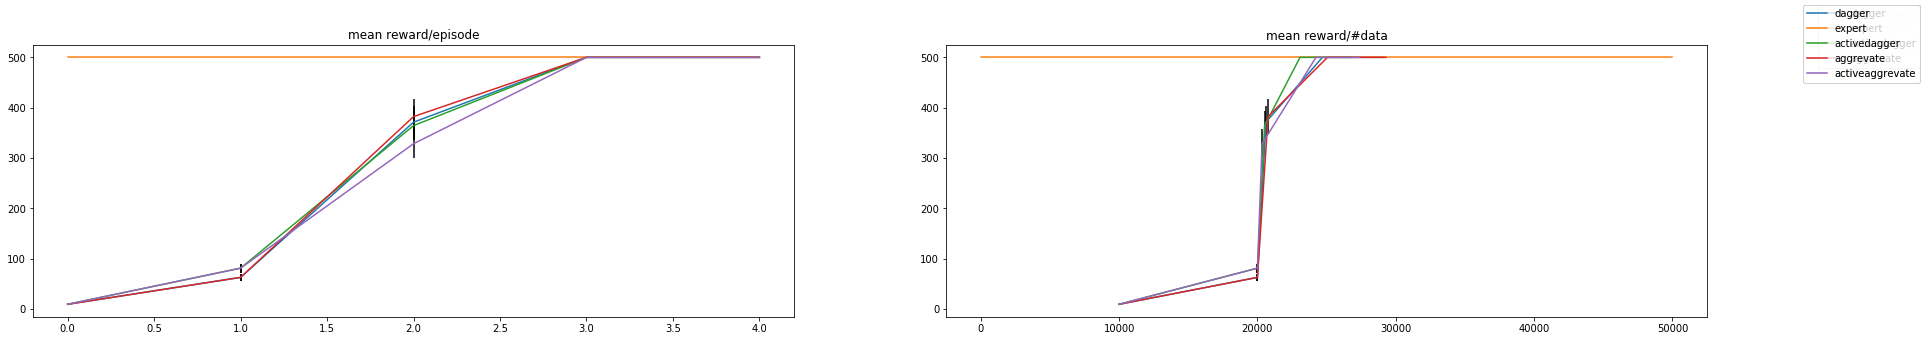

In [19]:
# cartpole
plot_and_evaluate()

In [147]:
active_aggrevate.save('./models/','test_policy_class')

In [150]:
#final_model = './models/{}_active_dagger_model.h5'.format(j)
final_model = './models/test_policy_class.h5'
!xvfb-run -s "-screen 0 600x400x24" python3.6 render.py --mpath $final_model --envname HalfCheetah-v2

100%|███████████████████████████████████████▉| 997/1000 [00:19<00:00, 51.42it/s]


In [151]:
for file in os.listdir("./gym-results/"):
    if file.endswith(".mp4"):   
        mp4name = os.path.join("./gym-results", file)
        print(mp4name)

./gym-results/openaigym.video.0.11286.video000000.mp4


In [152]:
video = io.open(mp4name, 'r+b').read()
encoded = base64.b64encode(video)
HTML(data='''
    <video width="360" height="auto" alt="test" controls><source src="data:video/mp4;base64,{0}" type="video/mp4" /></video>'''
.format(encoded.decode('ascii')))